# Blood sugar fast day

I am type 1 diabetic and require a constant monitoring of my glycemia (the concentration of glucose in my blood) in order to treat myself. I wear a continuous glucose monitor at all times and my glycemia is measured every 5 minutes. The goal of the treatment is to keep the glycemia in range. This is done by balancing the glucose intake (basically food) with insulin shots. At the beginning of July 2024, I did a 24 hours fast. This provided me with simplified data to analyse. Indeed, en everyday life, the three main components of diabetes treatment insulin, glucose and exercise, all happen together. For example, I inject insulin just before I eat my lunch so that both components compensate each other. In this simplified data set, I have 6 events where only one of the components is acting, independently from the others.

In this project, I analyse these events with a focus on time scales. In particular, I measure the time-scales on which each components affects my glycemia.

## Data preparation

In this section I import the data provided by my sensor from an excel file into a single DataFrame, I implement a smooth glycemia re-calibration and I select the data corresponding to my fast day.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import numpy as np

all_data = pd.read_excel('All Events.xlsx',sheet_name = 'Sensor Glucose').drop(columns = ['SensorID','UnitMeasureVal'])
# I'm only interested in 2 days of data. Cut out most of the data immediately.
date_window = [datetime(2024,7,1),datetime(2024,7,6)]
all_data = all_data[(pd.to_datetime(all_data['EventDateStr'])>=date_window[0]) & (pd.to_datetime(all_data['EventDateStr'])<=date_window[-1])].copy()
all_data['EventType'] = 'glycemia'

#include the insulin injection, eating and sport events
temp = pd.read_excel('All Events.xlsx',sheet_name = 'Patient Events')
temp = temp[(pd.to_datetime(temp['EventDateStr'])>=date_window[0]) & (pd.to_datetime(temp['EventDateStr'])<=date_window[-1])].copy()
temp.loc[temp['EventType'] == 'Insulin','UnitValue'] = temp.loc[temp['EventType'] == 'Insulin','UnitValue'].apply(lambda x: x[:-6])
temp.loc[temp['EventType'] == 'Meal','UnitValue'] = temp.loc[temp['EventType'] == 'Meal','UnitValue'].apply(lambda x: x[7:-6])
temp.loc[temp['EventType'] == 'Exercise','UnitValue'] = temp.loc[temp['EventType'] == 'Exercise','UnitValue'].apply(lambda x: x[10:-4])
temp.loc[temp['EventSubType'] == 'Type: Rapid Acting','EventType'] = 'rapid_insulin_u'
temp.loc[temp['EventSubType'] == 'Type: Long Acting','EventType'] = 'long_insulin_u'
# I took note of what I ate (sugar, chocolate, sugar, sugar), but had to look is up in my phone.
temp.loc[temp['EventType'] == 'Meal','EventType'] = ['rapid_glucose_g','slow_glucose_g','rapid_glucose_g','rapid_glucose_g']
temp.loc[temp['EventSubType'] == 'Intensity: High','EventType'] = 'high_exercise_min'
temp.loc[temp['EventSubType'] == 'Intensity: Medium','EventType'] = 'medium_exercise_min'
temp = temp.drop(columns = ['EventSubType']).rename(columns = {'UnitValue':'Value'})
all_data = pd.concat([all_data,temp])

#include the calibrations
temp = pd.read_excel('All Events.xlsx',sheet_name = 'Blood Glucose').drop(columns = ['UnitMeasureVal']).drop(columns = ['CalibrationMsg'])
temp = temp[(pd.to_datetime(temp['EventDateStr'])>=date_window[0]) & (pd.to_datetime(temp['EventDateStr'])<=date_window[-1])].copy()
temp['EventType'] = 'calibration'
all_data = pd.concat([all_data,temp])

all_data['Value'] = all_data['Value'].astype(float)
all_data.index = pd.to_datetime(all_data['EventDateStr'] + ' ' + all_data['EventTimeStr'])
all_data = all_data.sort_index()
all_data

/tmp/ipykernel_8276/3554722959.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data.index = pd.to_datetime(all_data['EventDateStr'] + ' ' + all_data['EventTimeStr'])


,EventDateStr,EventTimeStr,Value,EventType
2024-07-01 00:01:00,01-July-2024,12:01 AM,13.2,glycemia
2024-07-01 00:05:00,01-July-2024,12:05 AM,1.0,rapid_insulin_u
2024-07-01 00:06:00,01-July-2024,12:06 AM,12.7,glycemia
2024-07-01 00:11:00,01-July-2024,12:11 AM,12.4,glycemia
2024-07-01 00:16:00,01-July-2024,12:16 AM,12.7,glycemia
...,...,...,...,...
2024-07-06 23:38:00,06-July-2024,11:38 PM,8.6,glycemia
2024-07-06 23:43:00,06-July-2024,11:43 PM,8.3,glycemia
2024-07-06 23:48:00,06-July-2024,11:48 PM,8.2,glycemia
2024-07-06 23:53:00,06-July-2024,11:53 PM,7.9,glycemia


In [2]:
for type in all_data['EventType'].unique():
    if type != 'glycemia':
        display(all_data.loc[all_data['EventType'] == type,['Value', 'EventType']])

,Value,EventType
2024-07-01 00:05:00,1.0,rapid_insulin_u
2024-07-01 06:48:00,4.0,rapid_insulin_u
2024-07-01 08:22:00,4.0,rapid_insulin_u
2024-07-01 09:46:00,2.0,rapid_insulin_u
2024-07-01 12:15:00,6.0,rapid_insulin_u
2024-07-01 14:16:00,2.0,rapid_insulin_u
2024-07-01 16:46:00,4.0,rapid_insulin_u
2024-07-01 19:21:00,2.0,rapid_insulin_u
2024-07-01 19:40:00,4.0,rapid_insulin_u
2024-07-02 00:48:00,1.0,rapid_insulin_u


,Value,EventType
2024-07-01 06:48:00,12.2,calibration
2024-07-02 07:32:00,7.2,calibration
2024-07-03 06:40:00,12.1,calibration
2024-07-04 07:54:00,4.1,calibration
2024-07-05 07:40:00,4.2,calibration
2024-07-06 08:59:00,4.9,calibration


,Value,EventType
2024-07-01 07:09:00,18.0,long_insulin_u
2024-07-02 09:16:00,18.0,long_insulin_u
2024-07-03 06:42:00,17.0,long_insulin_u
2024-07-04 07:58:00,17.0,long_insulin_u
2024-07-05 07:42:00,17.0,long_insulin_u
2024-07-06 09:01:00,18.0,long_insulin_u


,Value,EventType
2024-07-03 12:10:00,40.0,medium_exercise_min


,Value,EventType
2024-07-03 13:38:00,10.0,rapid_glucose_g
2024-07-03 17:56:00,10.0,rapid_glucose_g
2024-07-04 04:36:00,10.0,rapid_glucose_g


,Value,EventType
2024-07-03 18:00:00,60.0,high_exercise_min


,Value,EventType
2024-07-03 22:31:00,10.0,slow_glucose_g


In [3]:
all_data[(all_data.index.duplicated(keep = False))]

,EventDateStr,EventTimeStr,Value,EventType
2024-07-01 06:48:00,01-July-2024,06:48 AM,12.2,calibration
2024-07-01 06:48:00,01-July-2024,06:48 AM,4.0,rapid_insulin_u
2024-07-01 09:46:00,01-July-2024,09:46 AM,5.5,glycemia
2024-07-01 09:46:00,01-July-2024,09:46 AM,2.0,rapid_insulin_u
2024-07-01 14:16:00,01-July-2024,02:16 PM,9.7,glycemia
2024-07-01 14:16:00,01-July-2024,02:16 PM,2.0,rapid_insulin_u
2024-07-01 16:46:00,01-July-2024,04:46 PM,4.0,rapid_insulin_u
2024-07-01 16:46:00,01-July-2024,04:46 PM,7.2,glycemia
2024-07-01 19:21:00,01-July-2024,07:21 PM,7.2,glycemia
2024-07-01 19:21:00,01-July-2024,07:21 PM,2.0,rapid_insulin_u


In [4]:
all_data['EventType'].unique()

array(['glycemia', 'rapid_insulin_u', 'calibration', 'long_insulin_u',
       'medium_exercise_min', 'rapid_glucose_g', 'high_exercise_min',
       'slow_glucose_g'], dtype=object)

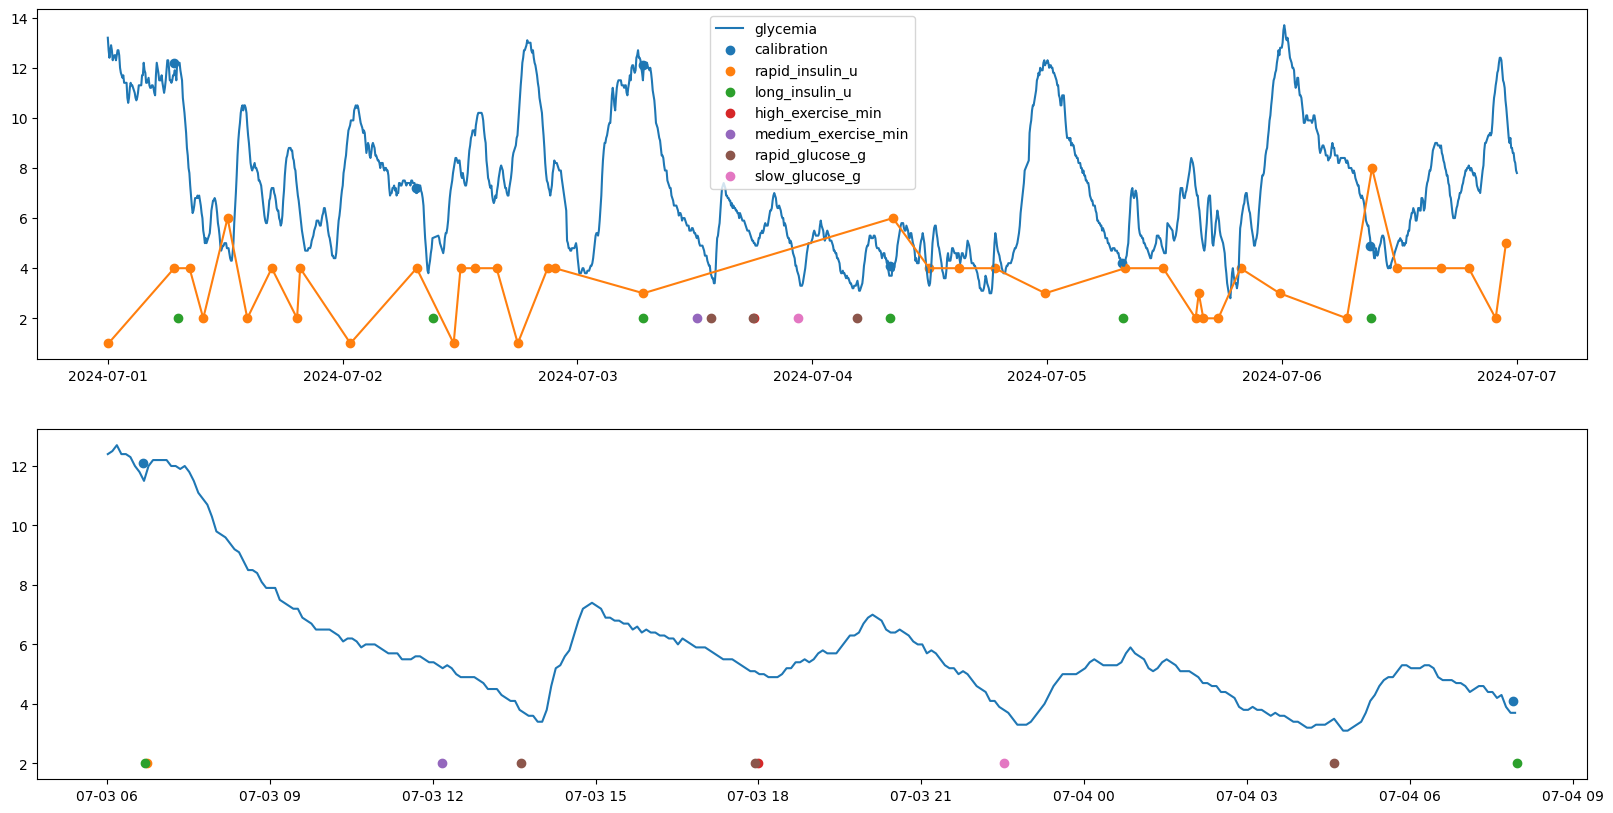

In [5]:
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)

data = all_data[all_data['EventType'] == 'glycemia'].copy()
axs[0].plot(data.index,data['Value'], label = 'glycemia')

data = all_data[all_data['EventType'] == 'calibration'].copy()
axs[0].scatter(data.index,data['Value'], label = 'calibration')

type = 'rapid_insulin_u'
data = all_data[all_data['EventType'] == type].copy()
axs[0].scatter(data.index,data['Value'], label = type)
axs[0].plot(data.index,data['Value'])
for type in ['long_insulin_u', 'high_exercise_min', 'medium_exercise_min', 'rapid_glucose_g', 'slow_glucose_g']:
    data = all_data[all_data['EventType'] == type].copy()
    axs[0].scatter(data.index,[2]*len(data), label = type)

axs[0].legend()

fast_start = datetime(2024,7,3,6)
fast_end = datetime(2024,7,4,8)
data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'glycemia')].copy()
axs[1].plot(data.index,data['Value'])

data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'calibration')].copy()
axs[1].scatter(data.index,data['Value'])

for type in ['rapid_insulin_u','long_insulin_u', 'high_exercise_min', 'medium_exercise_min', 'rapid_glucose_g', 'slow_glucose_g']:
    data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == type)].copy()
    axs[1].scatter(data.index,[2]*len(data))

The device is calibrated about once a day. The next 3 (my guess) measurements are then incrementally adjusted to catch up with the calibration. I model this by breaking the data into calibration intervals (time intervals between two calibrations) and adding a linear (in time) correction to the measured glycemia. The correction is set to be zero 3 measurements after each calibration and match the calibration at the measurement that comes just before the next measurement.

In [6]:
# Compute a calibration factor. The 3 measurements that come just after a calibration are already adjusted, they will be adjusted with a diminishing amplitude. The glucose correction is multiplied by (2/3,1/3,0).
all_data.loc[all_data['EventType'] == 'glycemia','calibration_factor'] = 1
for cal in all_data[all_data['EventType'] == 'calibration'].index:
    indices = all_data.loc[(all_data['EventType'] == 'glycemia') & (all_data.index >= cal),'calibration_factor'].head(3).index
    length = len(indices)
    all_data.loc[all_data.index.isin(indices),'calibration_factor'] = np.arange(2,-length+2,-1)/3

In [7]:
# Here I computed the calibrated glycemia.
zeros = all_data[(all_data['EventType'] == 'glycemia') & (all_data['calibration_factor'] == 0)].index
for ind, z in enumerate(zeros[1:]):
    data = all_data.loc[(all_data['EventType'] == 'glycemia') & (all_data.index <= z) & (all_data.index >= zeros[ind]),['Value','calibration_factor']].copy()
    data = pd.concat([data,pd.DataFrame([[np.nan, np.nan]],index = all_data[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind])].index,columns = data.columns)]).sort_index()
    data['Value'] = data['Value'].interpolate(method = 'time')
    data['elapsed_time'] = (data.index-data.index[0]).total_seconds()
    correction_slope = ((all_data.loc[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind]),'Value'] - data.loc[all_data[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind])].index,'Value'])/(z-zeros[ind]).total_seconds()).values[0]
    data['calibration_correction'] = correction_slope*data['elapsed_time']
    data['calibrated_glycemia'] = data['Value']+data['calibration_factor']*data['calibration_correction']
    all_data.loc[(all_data['EventType'] == 'glycemia') & (all_data.index <= z) & (all_data.index >= zeros[ind]),'calibrated_glycemia'] = data.loc[data.index.isin(all_data[(all_data['EventType'] == 'glycemia') & (all_data.index <= z) & (all_data.index >= zeros[ind])].index),'calibrated_glycemia']

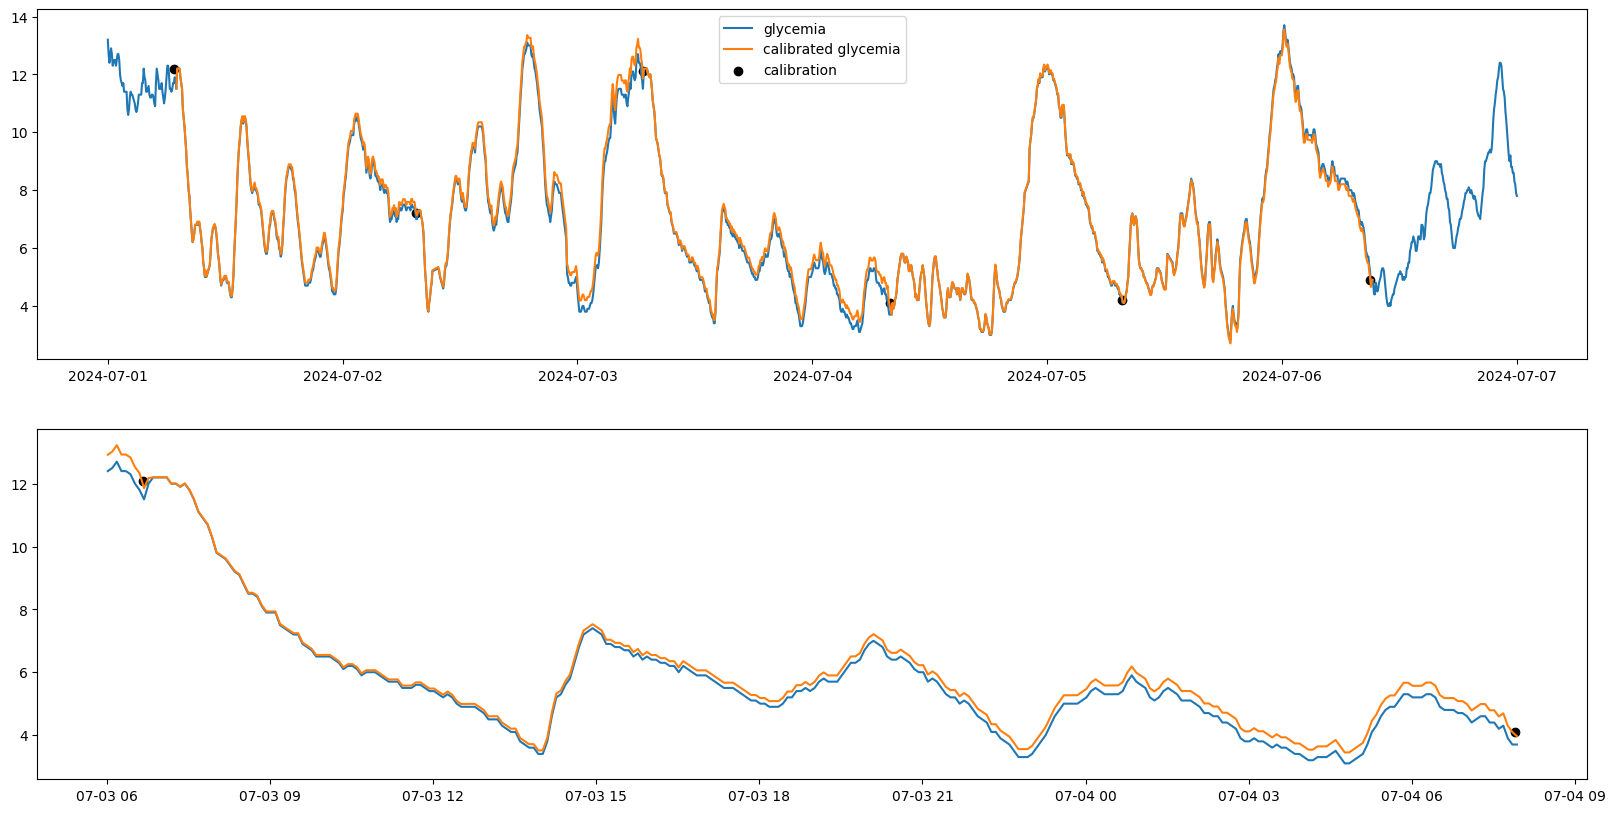

In [8]:
# It looks like it's working
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)

data = all_data[all_data['EventType'] == 'glycemia'].copy()
axs[0].plot(data.index,data['Value'], label = 'glycemia')
axs[0].plot(data.index,data['calibrated_glycemia'], label = 'calibrated glycemia')

data = all_data[all_data['EventType'] == 'calibration'].copy()
axs[0].scatter(data.index,data['Value'], label = 'calibration', color = 'k')

axs[0].legend()

fast_start = datetime(2024,7,3,6)
fast_end = datetime(2024,7,4,8)
data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'glycemia')].copy()
axs[1].plot(data.index,data['Value'], label = 'glycemia')
axs[1].plot(data.index,data['calibrated_glycemia'], label = 'calibrated glucose')

data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'calibration')].copy()
axs[1].scatter(data.index,data['Value'], label = 'calibration', color = 'k');

In [9]:
# save the relevant data to a csv file to use later
all_data.loc[(all_data.index < fast_end) & (all_data.index > fast_start),['Value', 'EventType', 'calibrated_glycemia']].copy().to_csv('fast_day.csv')

## Rapid insulin action curve

In this section I take advantage of the high night-time glycemia and ensuing insulin injection. This event provides about 6 hours of glycemia where insulin is acting without any other influences.

I model the insulin action with an exponential decay. I assume that the time derivative of the glycemia behaves as

$$ g'(t) = - C - A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-(t-t_0)/\tau} \theta(t-t_0)  \;,$$

with $\theta(t) = \frac{t+|t|}{2 t}$, the heaviside function. It is zero if $t<t_0$ and one otherwise. $t_0$ is the time at which the insulin's effect becomes visible in the sensor. The second term on the right-hand-side can be interpreted as the **insulin action**. When it is zero, the glucose value only drifts. The insulin action term is negative. It can only decrease the glycemia. This model encodes the following phenomena:
- The delayed action of the insulin: Insulin takes some time to reach the blood stream and start to lower the glycemia. Moreover, the glycemia reading from the sensor is also delayed because it actually measures the glucose concentration in the interstitial fluid instead of the blood. This feature is encoded in the $t-t_0$ argument of the exponential and the heaviside function. $t_0$ is the corresponding time delay. In particular the heaviside function $\theta(t)$ ensures that the insulin action is zero as long as $t< t_0$.
- The amplitude of the effect of the shot on the body: More insulin will induce a larger decrease of glycemia. This is encoded in the constant $A$ that I expect is proportional to the injected dose. $A$ has the same physical unit as the glycemia, mmol/l.
- The decay of the effect of insulin over a few hours: Rapid insulin has an effect on glycemia that rapidly ramps up at first and then stops after a few hours. This is encoded in the $t \exp(-t/\tau)$ part. For small values of $t$, this term is small and proportional to $t$. It grows and hits a maximum at $t= \tau$ and then decays exponentially. $\tau$ is the time scale of this phenomenon.
- The eventual effect of the long acting insulin: A long acting insulin that is not perfectly dosed will induce a slow drift of the glycemia. This effect is captured by the constant C.

The model ignores the fact that the glycemia can not go below zero. In practice, this is rarely a problem because when it drops too low, I compensate with some sugar. I have however noticed that there seems to be some kind of insulin resistance when $g$ is low. In particular, at times when the glycemia is dropping slowly, it never goes below about 2 mmol/l. From the above model (that is valid here because there are no other influences on the glycemia and because the glycemia is quite high), we can infer the time-dependence of the glucose value as

$$g(t) = g_0 - C \, t - \theta(t-t_0) \, \frac{A}{\tau} \, \left[\tau-\text{e}^{-(t-t_0)/\tau} (t-t_0+\tau) \right] \, . $$

$g_0$ is the observed glycemia at the moment of the insulin injection, $t=0$. This model has the following properties:
- $ g(t<t_0) = g_0 - C \,t $. Before the insulin kicks in, the glycemia linearly drifts.
- $g(t = t_0 + \epsilon) \cong g_0 - C \ (t_0 + \epsilon) - \frac{A}{2} \left(\frac{\epsilon}{\tau}\right)^2$, for $\epsilon \ll \tau$. The effect of the insulin kicks in smoothly as $(t-t_0)^2$. It is proportional to $A$.
- $g(t \gg \tau) = g_0 - C \, t - A$. When the insulin effect is finished, the glycemia returns to a slow drift with a value that is decreased by $A$. The insulin injection has decreased the glycemia by $A$.

Here, I fit the above model to my data and extract numerical values for $g_0$, $C$, $t_0$, $A$ and $\tau$.

In [1]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
# The insulin is acting alone immediately after my first (and only in this dataset) injection and right before I went to collect my daughter at kindergarden.
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = data[data['EventType'] == 'rapid_insulin_u'].index, columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = data[data['EventType'] == 'medium_exercise_min'].index, columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']] = data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']].interpolate(method = 'time')
data = data.loc[(data['EventType'] == 'glycemia') & (data.index >= data[data['EventType'] == 'rapid_insulin_u'].index[0]) & (data.index <= data[data['EventType'] == 'medium_exercise_min'].index[0]),['Value','calibrated_glycemia']]
data['elapsed_time_h'] = (data.index-data.index[0]).total_seconds()/(3600)
display(data)

def theta(x):
    # I use a smooth version of the heaviside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def tofit(t,C, g0,t0,A,tau):
    # This is the model described above.
    return g0-C*t+theta(t-t0)*(A/tau)*(
        (tau+t-t0)*np.exp(-(t-t0)/tau)-tau
        )

def insulin_action(t,C, g0,t0,A,tau):
    # This is the insulin action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

epsilon = 0.2
def to_zero(x):
    # finding x so that this returns zero provides the time when the glycemia level has decreased by 1-epsilon.
    return (1+x)*np.exp(-x)-epsilon

,Value,calibrated_glycemia,elapsed_time_h
time,,,
2024-07-03 06:44:00,11.80,12.050570,0.000000
2024-07-03 06:46:00,12.00,12.179350,0.033333
2024-07-03 06:51:00,12.20,12.200000,0.116667
2024-07-03 06:56:00,12.20,12.201320,0.200000
2024-07-03 07:01:00,12.20,12.202640,0.283333
...,...,...,...
2024-07-03 11:51:00,5.50,5.579208,5.116667
2024-07-03 11:56:00,5.40,5.480528,5.200000
2024-07-03 12:01:00,5.40,5.481848,5.283333


Below, I fit the model described above to the data. I show a figure and a table. The figure contains

- the measured glycemia (blue dots)
- the fitted glycemia (blue line)
- the evolution of the glycemia predicted by the model without insulin (i.e. just the drift term) (orange line)
- the scaled insulin action (green line).

The table summarises useful statistics and measurements extracted from the model:

- mae: The mean average error is a standard estimation of model quality. It is the mean of the absolute value of the differences between the measured and predicted data. Is is given in mmol/l and can be directly interpreted as the typical size of the error that the model makes.
- rmse: The root mean squared error is another estimator of model quality. It is the square root of the mean of the squares of the differences between the measured and predicted data. Is is als given in mmol/l and can be directly interpreted and the typical size of the error that the model makes.
- Slow drift [mmol/(lh)]: The drift parameter C in the model.
- Action delay [minutes]: The delay parameter $t_0$ in the model.
- Action time scale [minutes]: The time scale parameter $\tau$ in the parameter.
- Total glycemia decrease [mmol/l]: The change in glycemia that is a result of the insulin shot (without the drift).
- Time to 80% [hours]: The time to wait since the injection for the glycemia to decrease by 80% of its total decrease.

,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia decrease [mmol/l],Time to 80.0% [hours]
Event start,,,,,,,
2024-07-03 06:44:00,0.077,0.104,0.375,28.524,41.236,4.859,2.533


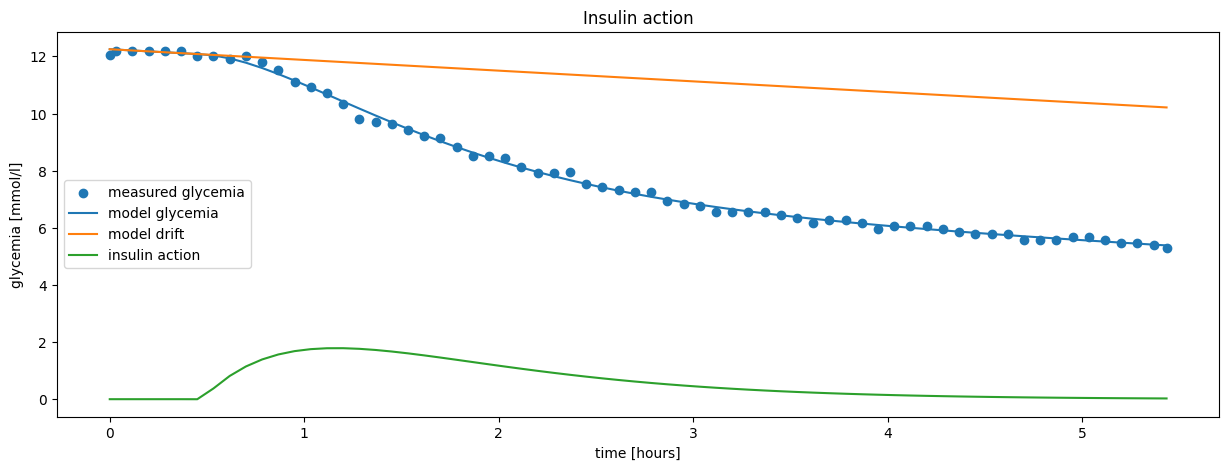

In [2]:
popt, _ = curve_fit(tofit, data['elapsed_time_h'],data['calibrated_glycemia'], p0 = [0, 12,0.75,11.5,0.6])
time_solution = fsolve(to_zero, 1)

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glycemia'], label = 'measured glycemia')
axs.plot(data['elapsed_time_h'],tofit(data['elapsed_time_h'], *popt), label = 'model glycemia')
axs.plot(data['elapsed_time_h'],popt[1]- popt[0]*data['elapsed_time_h'], label = 'model drift')
axs.plot(data['elapsed_time_h'],insulin_action(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.set_xlabel('time [hours]')
axs.set_ylabel('glycemia [mmol/l]')
axs.set_title('Insulin action')
axs.legend();

columns = ['mae [mmol/l]','rmse [mmol/l]', 'Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia decrease [mmol/l]','Time to '+str(100*(1-epsilon))+'% [hours]']
values = ([np.abs(data['calibrated_glycemia']-tofit(data['elapsed_time_h'], *popt)).mean(),
(((data['calibrated_glycemia']-tofit(data['elapsed_time_h'], *popt))**2).mean()**0.5), data.index[0],
popt[0], popt[2]*60, popt[4]*60, popt[3],popt[2]+popt[4]*time_solution[0]])
round(pd.DataFrame([values],columns = columns, index = ['']).set_index('Event start'),3)

The model looks like it's working well. The errors are small and more or less randomly distributed around the fit. The drift matches the data until the delay time and the decrease in glycemia returns to a drift with the same parameter after the insulin action has ended. The insulin action ends within the window of observed data.

Nevertheless, I try below an alternative model with

$$ g'(t) = - C - A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-1/2[(t-t_0)/\tau]^2} \theta(t-t_0)  \;.$$

It works in the same way as the model described above.

,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia decrease [mmol/l],Time to 80.0% [hours]
Event start,,,,,,,
2024-07-03 06:44:00,0.093,0.13,0.527,16.104,66.264,4.131,2.25


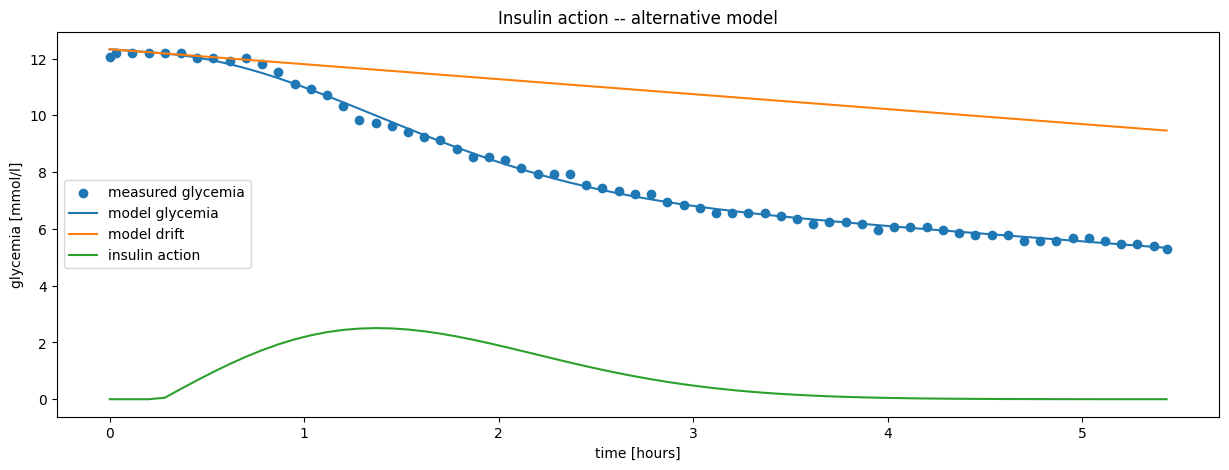

In [3]:
def tofit_square(t,C, g0,t0,A,tau):
    # This is the alternative model.
    return g0-C*t-theta(t-t0)*A*(1-np.exp(-0.5*(t-t0)**2/tau**2))

def insulin_action_square(t,C, g0,t0,A,tau):
    # This is the corresponding insulin action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-0.5*(t-t0)**2/tau**2)/(tau**2)

popt, _ = curve_fit(tofit_square, data['elapsed_time_h'],data['calibrated_glycemia'], p0 = [0, 12,0.75,11.5,0.6])
epsilon = 0.2
time_solution = [(-2*np.log(epsilon))**0.5]

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glycemia'], label = 'measured glycemia')
axs.plot(data['elapsed_time_h'],tofit_square(data['elapsed_time_h'], *popt), label = 'model glycemia')
axs.plot(data['elapsed_time_h'],popt[1]- popt[0]*data['elapsed_time_h'], label = 'model drift')
axs.plot(data['elapsed_time_h'],insulin_action_square(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.set_xlabel('time [hours]')
axs.set_ylabel('glycemia [mmol/l]')
axs.set_title('Insulin action -- alternative model')
axs.legend();

columns = ['mae [mmol/l]','rmse [mmol/l]', 'Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia decrease [mmol/l]','Time to '+str(100*(1-epsilon))+'% [hours]']
values = ([np.abs(data['calibrated_glycemia']-tofit_square(data['elapsed_time_h'], *popt)).mean(),
(((data['calibrated_glycemia']-tofit_square(data['elapsed_time_h'], *popt))**2).mean()**0.5), data.index[0],
popt[0], popt[2]*60, popt[4]*60, popt[3],popt[2]+popt[4]*time_solution[0]])
round(pd.DataFrame([values],columns = columns, index = ['']).set_index('Event start'),3)

Comparing the two models, I slightly prefer the first one because:

- Both (mae and mse) scores are better.
- The action delay time fits better with what I was taught.

In any case, the two models provide more or less compatible result. The only real difference is the insulin action delay measurement: about 29 (first model) and 16 (second model) minutes. The action time scales also differ significantly, but these are model parameters and do not need to match exactly. The total glycemia decreases and the time to reach 80% of the total decrease more or less match.

I see from this analysis that my long acting insulin is a bit overdosed. I could lessen the drift term by injecting a little less of it. I will also keep in mind the time scale of 2.533 hours for the action of the rapid insulin. For now, I have the following questions:

- How does this depend on the amount of insulin injected? In this case, the dose was 3 clicks. Assuming that A is proportional to the number of insulin doses, then I have a glycemia decrease of about 4.859/3 = 1.620 [mmol/(l*dose)]. Is this a good assumption?
- How does this depend on the time of the day? My body surely reacts differently at different times.
- Where can I find insulin action curves in the literature? I would like to compare this to something.

## Food action curve

In this section, I repeat the above analysis, but with my sugar intakes instead of insulin action. During the fast day, I ate carbohydrates 4 times. 3 of them were white sugar (fast acting) and one was dark chocolate (slow acting). All these events were in the second half of the day and can be assumed to be independent of the rapid acting insulin injection. One of the rapid sugar intakes corresponds to a high intensity exercise event and will be discarded. The other 3 events are assumed to be independent from insulin and exercise. The model is essentially the same as before

$$ g'(t) = - C + A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-(t-t_0)/\tau} \theta(t-t_0)  \;,$$

with the difference that the glycemia goes up. $t_0$ only reflects the delay in the sensor measurement and is expected to be smaller this time.

As before, I fit the model and provide figures and a table. This time, there is one figure for each event and all three events are grouped in a single table.

In [1]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
data = data.sort_index()

# Make a dictionary with the three carbohydrate intake events.
carb_events_start = [data[data['EventType'] == 'rapid_glucose_g'].index[0], data[data['EventType'] == 'slow_glucose_g'].index[0], data[data['EventType'] == 'rapid_glucose_g'].index[-1]]
events = []
for ev in carb_events_start:
    ev_end = data[(data['EventType'] != 'glycemia') & (data['EventType'] != 'calibration') & (data.index >= ev)].iloc[1].name
    data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = [ev,ev_end], columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
    data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']] = data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']].interpolate(method = 'time')

    temp = data.loc[(data.index <= ev_end) & (data.index >= ev) & (data['EventType'] == 'glycemia'),['Value','calibrated_glycemia']].sort_index()
    temp['elapsed_time_h'] = (temp.index-temp.index[0]).total_seconds()/(3600)
    temp = temp[temp['elapsed_time_h']<4]
    temp.index.name = ev
    events.append(temp)

for ev, type in zip(events,['rapid_glucose_g','slow_glucose_g','rapid_glucose_g']):
    ev.columns.name = type

def theta(x):
    # I use a smooth version of the heaviside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def tofit(t,C, g0,t0,A,tau):
    # This is the model described above.
    return g0-C*t-theta(t-t0)*(A/tau)*(
        (tau+t-t0)*np.exp(-(t-t0)/tau)-tau
        )

def glucose_action(t,C, g0,t0,A,tau):
    # This is the glucose action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

def tofit_square(t,C, g0,t0,A,tau):
    # This is the alternative model.
    return g0-C*t+theta(t-t0)*A*(1-np.exp(-(t-t0)**2/tau**2))/2

def glucose_action_square(t,C, g0,t0,A,tau):
    # This is the corresponding glucose action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)**2/tau**2)/(tau**2)

epsilon = 0.2
def to_zero(x):
    # finding x so that this returns zero provides the time when the glycemia level has increased by 1-epsilon.
    return (1+x)*np.exp(-x)-epsilon

,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia increase [mmol/l],Time to 80.0% [hours]
Event start,,,,,,,,
2024-07-03 13:38:00,rapid_glucose_g,0.121,0.165,0.698,21.222,12.841,4.492,0.995
2024-07-03 22:31:00,slow_glucose_g,0.134,0.156,0.727,16.882,29.792,3.944,1.768
2024-07-04 04:36:00,rapid_glucose_g,0.100,0.121,0.959,17.596,18.010,3.607,1.192


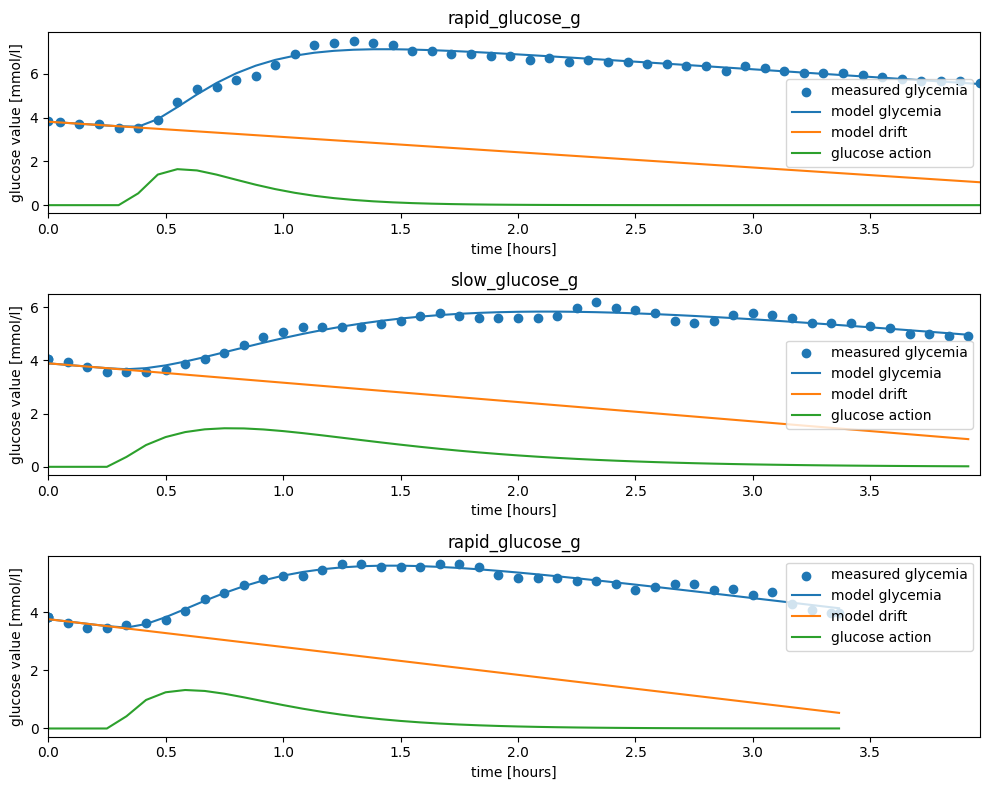

In [2]:
fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(10)

max_time = 0
for ev in events:
    max_time = max(max_time,ev['elapsed_time_h'].max())

events_description = pd.DataFrame(['rapid_glucose_g','slow_glucose_g','rapid_glucose_g'],index = [0,1,2],columns = ['EventType'])

for ind, ev in enumerate(events):

    popt, _ = curve_fit(tofit, ev['elapsed_time_h'],ev['calibrated_glycemia'], p0 = [0, 3,0.75,4,0.6])
    time_solution = fsolve(to_zero, 1)

    axs[ind].scatter(ev['elapsed_time_h'],ev['calibrated_glycemia'], label = 'measured glycemia')
    axs[ind].plot(ev['elapsed_time_h'],tofit(ev['elapsed_time_h'], *popt), label = 'model glycemia')
    axs[ind].plot(ev['elapsed_time_h'],popt[1]-popt[0]*ev['elapsed_time_h'], label = 'model drift')
    axs[ind].plot(ev['elapsed_time_h'],glucose_action(ev['elapsed_time_h'], *popt), label = 'glucose action')
    axs[ind].set_title(ev.columns.name)
    axs[ind].set_xlim([0,max_time])
    axs[ind].legend()
    axs[ind].set_xlabel('time [hours]')
    axs[ind].set_ylabel('glucose value [mmol/l]')

    columns = ['mae [mmol/l]','rmse [mmol/l]','Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia increase [mmol/l]','Time to '+str(100*(1-epsilon))+'% [hours]']
    values = ([np.abs(ev['calibrated_glycemia']-tofit(ev['elapsed_time_h'], *popt)).mean(),
    (((ev['calibrated_glycemia']-tofit(ev['elapsed_time_h'], *popt))**2).mean()**0.5),
    ev.index[0],
    popt[0],
    popt[2]*60,
    popt[4]*60,
    popt[3],popt[2]+popt[4]*time_solution[0]])
    events_description.loc[ind,columns] = values
fig.tight_layout();
events_description = events_description.set_index('Event start')
round(events_description,3)

,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia increase [mmol/l],Time to 80.0% [hours]
Event start,,,,,,,,
2024-07-03 13:38:00,rapid_glucose_g,0.110,0.150,0.666,15.864,33.487,8.807,0.972
2024-07-03 22:31:00,slow_glucose_g,0.157,0.180,0.515,9.813,64.319,6.422,1.524
2024-07-04 04:36:00,rapid_glucose_g,0.106,0.127,0.847,11.822,42.641,6.604,1.099


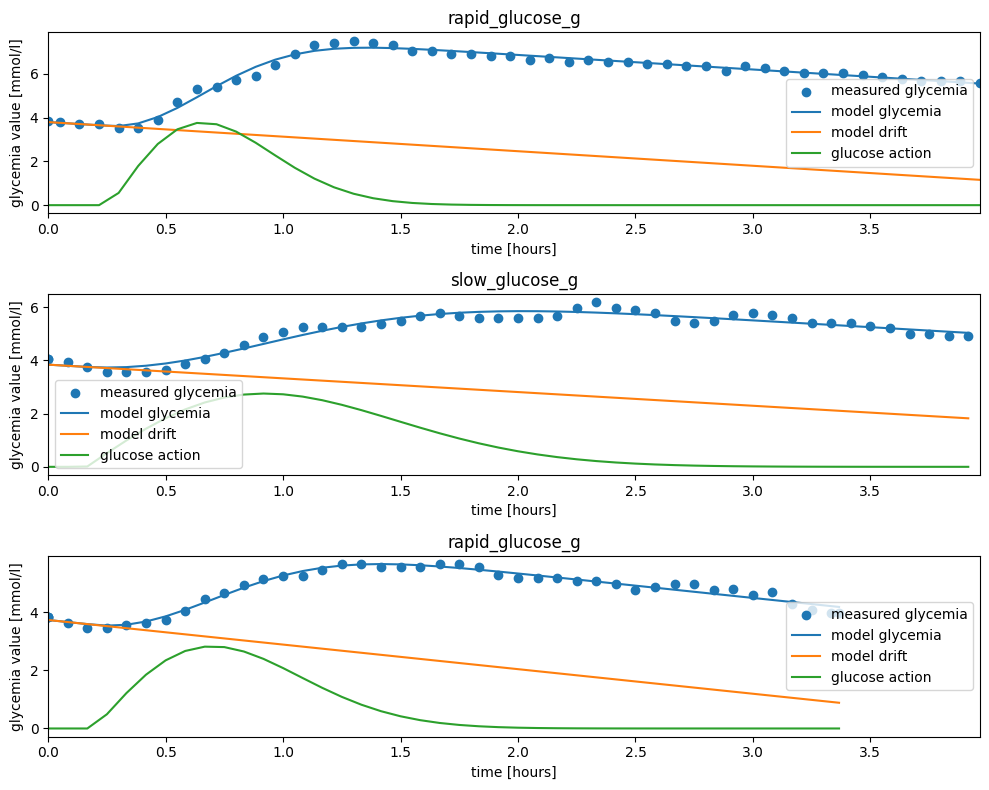

In [3]:
fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(10)

max_time = 0
for ev in events:
    max_time = max(max_time,ev['elapsed_time_h'].max())

events_description = pd.DataFrame(['rapid_glucose_g','slow_glucose_g','rapid_glucose_g'],index = [0,1,2],columns = ['EventType'])

for ind, ev in enumerate(events):

    popt, _ = curve_fit(tofit_square, ev['elapsed_time_h'],ev['calibrated_glycemia'], p0 = [0, 3,0.75,4,0.6])
    time_solution = [(-np.log(epsilon))**0.5]

    axs[ind].scatter(ev['elapsed_time_h'],ev['calibrated_glycemia'], label = 'measured glycemia')
    axs[ind].plot(ev['elapsed_time_h'],tofit_square(ev['elapsed_time_h'], *popt), label = 'model glycemia')
    axs[ind].plot(ev['elapsed_time_h'],popt[1]-popt[0]*ev['elapsed_time_h'], label = 'model drift')
    axs[ind].plot(ev['elapsed_time_h'],glucose_action_square(ev['elapsed_time_h'], *popt), label = 'glucose action')
    axs[ind].set_title(ev.columns.name)
    axs[ind].set_xlim([0,max_time])
    axs[ind].legend()
    axs[ind].set_xlabel('time [hours]')
    axs[ind].set_ylabel('glycemia value [mmol/l]')

    columns = ['mae [mmol/l]','rmse [mmol/l]','Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia increase [mmol/l]','Time to '+str(100*(1-epsilon))+'% [hours]']
    values = ([np.abs(ev['calibrated_glycemia']-tofit_square(ev['elapsed_time_h'], *popt)).mean(),
    (((ev['calibrated_glycemia']-tofit_square(ev['elapsed_time_h'], *popt))**2).mean()**0.5),
    ev.index[0],
    popt[0],
    popt[2]*60,
    popt[4]*60,
    popt[3],popt[2]+popt[4]*time_solution[0]])
    events_description.loc[ind,columns] = values
fig.tight_layout();
events_description = events_description.set_index('Event start')
round(events_description,3)

Second model has better score for rapid sugar and worse score for slow glucose.

As before, the action delay is sorter for the second model.

The action time scale is about 

It looks like the slow drift gets faster as the day progresses. I need less long acting insulin during the day. Or the long insulin has it's own action curve and becomes more active during the day.

## Effect of exercise

todo